In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

In [2]:
data_route = "C:\\workspace\\project_final\\data\\dataset_sample_10percent.csv"
data = pd.read_csv(data_route, encoding='utf-8')

In [3]:
# 결과를 담을 리스트
outliers_data = []

# Z-score 계산 및 이상치 여부 확인 함수ㅊ
def calculate_z_scores(df, group_column):
    # 그룹 내에서 가격에 대한 Z-score 계산
    df[f'{group_column}_zscore'] = df.groupby(group_column)['price'].transform(lambda x: zscore(x, ddof=0))
    return df

# 기준 컬럼별로 Z-score 계산 및 이상치 판단
data = calculate_z_scores(data, 'cate2_nm')
data = calculate_z_scores(data, 'supplier_code')
data = calculate_z_scores(data, 'class_name')
data = calculate_z_scores(data, 'brand_name')


In [4]:
data= data.dropna(subset=['supplier_code_zscore', 'cate2_nm_zscore', 'class_name_zscore', 'brand_name_zscore'])

z_score_columns = [
    'supplier_code_zscore',
    'cate2_nm_zscore',
    'class_name_zscore',
    'brand_name_zscore'
]

# LOF 모델 초기화
lof = LocalOutlierFactor(n_neighbors=1000)  # n_neighbors는 필요에 따라 조정

# 모델 적합 및 이상치 예측
data['lof_outlier'] = lof.fit_predict(data[z_score_columns])

# 이상치 표시 (-1은 이상치로 표시됨)
data['lof_outlier'] = data['lof_outlier'] == -1

In [6]:
outlier_list = data[data['lof_outlier']].copy()  # 이상치 데이터 복사
display(outlier_list[['prd_id', 'cate2_nm', 'supplier_code', 'class_name', 'brand_name', 
                  'cate2_nm_zscore','supplier_code_zscore', 'class_name_zscore', 'brand_name_zscore', 
                  'lof_outlier', 'price']])

,prd_id,cate2_nm,supplier_code,class_name,brand_name,cate2_nm_zscore,supplier_code_zscore,class_name_zscore,brand_name_zscore,lof_outlier,price
45,1050238890,침대,1044586,침대,퍼닉에스엠,-0.750248,0.132822,-0.715687,0.132822,True,239000
53,22401090,수납가구,1012574,수납장,꿈에그린,0.394502,-1.272510,1.121265,-1.681874,True,498000
90,96615210,수납가구,1034195,거실장/장식장,베이직가구,2.454774,-0.630562,1.203148,-0.630562,True,1630000
94,1041348378,화장대,1019672,화장대,인우드,-0.115045,0.040433,-0.030755,-0.049612,True,304900
95,1033541856,침대,1045945,침실세트,우드토픽,-0.771061,-1.402482,-1.495124,-1.402482,True,215000
...,...,...,...,...,...,...,...,...,...,...,...
1591662,1060267298,휴대폰케이스,1040823,핸드폰 액세서리,테일즈,0.551113,-0.018570,0.374429,-0.018570,True,19500
1591663,1062331089,휴대폰케이스,1047551,핸드폰 액세서리,핫트랙스,-0.552543,-0.166915,-0.433704,-0.166952,True,9700
1591682,1032373307,휴대폰케이스,1047551,핸드폰 액세서리,핫트랙스,-0.068286,-0.089813,-0.079115,-0.089848,True,14000
1591703,1051127820,휴대폰케이스,1022174,핸드폰 액세서리,SELLERHUBSHOP,-1.430963,-0.470362,-1.076912,-0.444088,True,1900


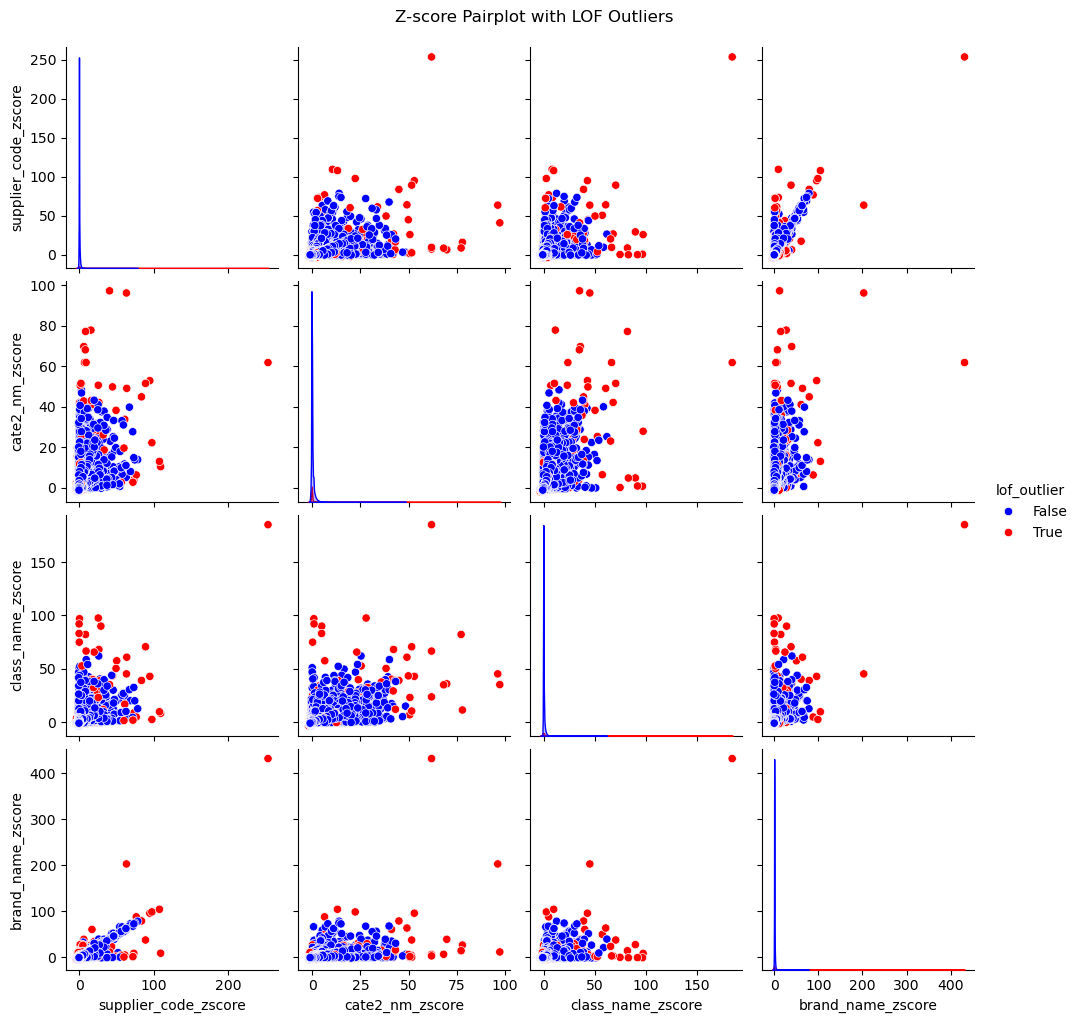

In [81]:
# 4개의 Z-score가 포함된 데이터프레임
z_score_columns = [
    'supplier_code_zscore',
    'cate2_nm_zscore',
    'class_name_zscore',
    'brand_name_zscore',
    'lof_outlier'  # 이상치 여부 컬럼 추가
]

# 페어플롯 생성
sns.pairplot(data[z_score_columns], hue='lof_outlier', palette={True: 'red', False: 'blue'})
plt.suptitle('Z-score Pairplot with LOF Outliers', y=1.02)
plt.show()

In [ ]:
# 각 항목에서 Z-score 기준을 넘는 경우만을 이상치로 판단
data['overall_outlier'] = (
    (data['supplier_code_zscore'].abs() > z_threshold) &
    (data['cate2_nm_zscore'].abs() > z_threshold) &
    (data['class_name_zscore'].abs() > z_threshold) &
    (data['brand_name_zscore'].abs() > z_threshold)
)

# 'overall_outlier'가 True인 데이터만 필터링
strict_outliers = data[data['overall_outlier'] == True]

# 결과 출력
print("네 가지 기준 모두에서 Z-score를 초과한 이상치 개수:", len(strict_outliers))
display(strict_outliers[['prd_id', 'cate2_nm', 'supplier_code', 'class_name', 'brand_name', 
                         'cate2_nm_zscore', 'supplier_code_zscore', 'class_name_zscore', 'brand_name_zscore', 
                         'overall_outlier', 'price']])


In [28]:
outliers = data[data['overall_outlier'] == True]

# 필요한 컬럼만 선택해서 출력


,prd_id,supplier_code,class_name,brand_name,supplier_code_zscore,class_name_zscore,brand_name_zscore,overall_outlier,price
96,1062508038,1009860,침대,현대의료기,3.564193,3.429867,3.577302,True,5230000
288,1055959166,1022174,서랍/정리함,SELLERHUBSHOP,4.354835,4.991407,4.102680,True,445300
352,1056885668,1051839,주방용품 기타,기타,3.159503,10.087541,3.037279,True,724770
404,1055883087,1022174,서랍/정리함,SELLERHUBSHOP,3.388490,3.898674,3.192096,True,356500
650,1056244965,1022174,서랍/정리함,SELLERHUBSHOP,4.439716,5.087390,4.182664,True,453100
...,...,...,...,...,...,...,...,...,...
1588445,27808695,1031568,핸드폰 액세서리,쇼베뉴엘,3.218066,8.381539,3.211342,True,116600
1588500,1052430345,1036305,핸드폰 액세서리,VERAX,4.389077,3.260617,3.938848,True,54500
1589891,1060780773,1040823,핸드폰 액세서리,테일즈,3.087230,2.221589,3.087230,True,41900
1590011,1017439948,1036305,핸드폰 액세서리,VERAX,3.967197,2.963752,3.538914,True,50900
